In [84]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
def f(x):
    return 3*x**2 - 4*x + 5

In [86]:
f(3.0)

20.0

In [87]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

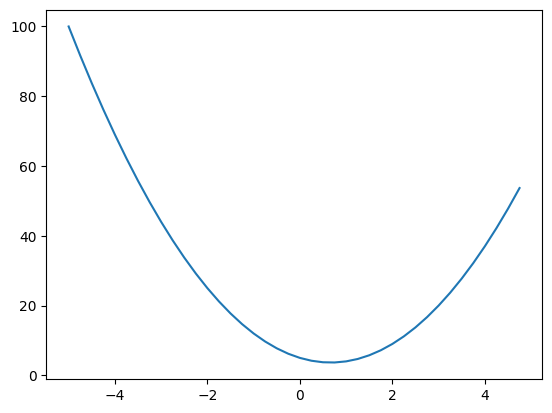

In [88]:
plt.plot(xs, ys)

In [89]:
h = 0.00000001
x = -3.0
(f(x + h) - f(x))/h

-22.00000039920269

In [90]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [91]:
h = 0.001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c

print( 'd1', d1)
print( 'd2', d2)
print( 'slope', (d2-d1) / h)


d1 4.0
d2 4.0009999999999994
slope 0.9999999999994458


In [170]:
class Value:
    
    def __init__(self, data, _children=[], _op='', label =''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward
        
        return out

    def __rtruediv__(self, other): # other / self
        neg = self**-1
        neg.label = 'pow(-1)'
        return other * neg

    def __truediv__(self, other):
        neg = other**-1
        neg.label = 'pow(-1)'
        return self * neg
        
    def __rmul__(self, other):
        return self * other
        
    def __radd__(self, other):
        return self + other
        
    def __rsub__(self, other): # other - self
        return other + (-self)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
                    

In [165]:
a = Value(2.0)
b = Value(4.0)
a/b
b-a

Value(data=2.0)

In [166]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [167]:
from graphviz import  Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR: left to right
    nodes, edges = trace(root)
    for n in nodes:
        uuid= str(id(n))
        dot.node(name=uuid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uuid + n._op, label=n._op)
            dot.edge(uuid + n._op, uuid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot
    
    

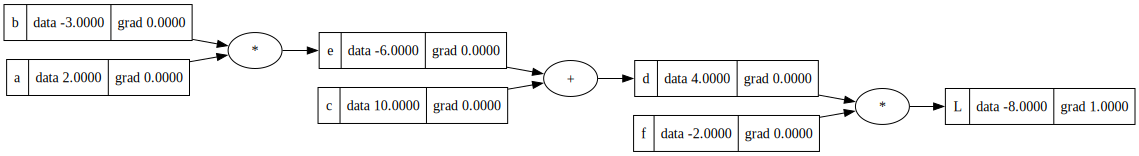

In [168]:
L.grad = 1.0
draw_dot(L)

In [97]:
L.grad = 1.0

In [98]:
# dl/dd = f
# dl/df = d
d.grad = f.data
f.grad = d.data

# dd/dc = 1
# dd/de = 1
# dl/dc = dd/dc * dl/dd = 1 * f 
# dl/de = dd/de * dl/dd = 1 * f 
c.grad = f.data
e.grad = f.data

d = c + e 

# de/da = b
# de/db = a
# dl/da = dl/dd * dd/de * de/da = f * 1 * b = f * b
# dl/db = dl/dd * dd/de * de/db = f * 1 * a = f * a
a.grad = f.data * b.data
b.grad = f.data * a.data

# a.grad = -2.0 * -3.0
# b.grad = -2.0 * 2.0

# c.grad = -2.0
# e.grad = -2.0

In [99]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L.data += h
    L2 = L.data

    print ( (L2 - L1) / h )
    
lol()

1.000000000000334


In [100]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


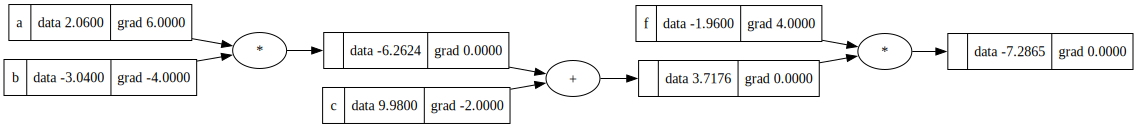

In [101]:
draw_dot(L)

# Backprop with Neurons

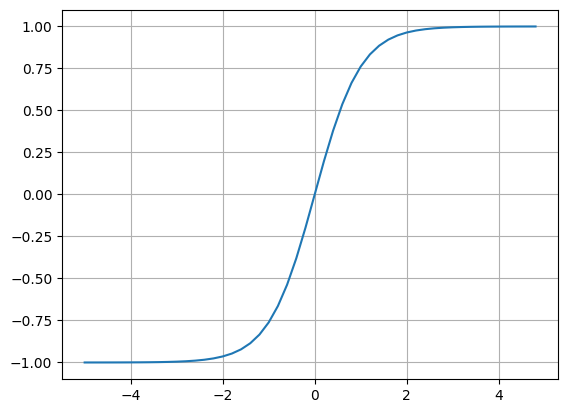

In [102]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [156]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813, label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'
o.backward()

In [157]:
# o = tanh(n)
# do/dn = 1- tanh(n)**2
# do/dn = 1- o**2
# 
# o.grad = 1.0
# n.grad = 1 - o.data**2 # ~0.5

# x1w1x2w2.grad = n.grad
# b.grad = n.grad

# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# # do/dx2 = dx2w2/dx2 * dx1w1x2w2/dx2w2 * dn/dx1w1x2w2 * do/dn
# # do/dx2 = w2 * dx1w1x2w2/dx2w2 * dn/dx1w1x2w2 * do/dn
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad



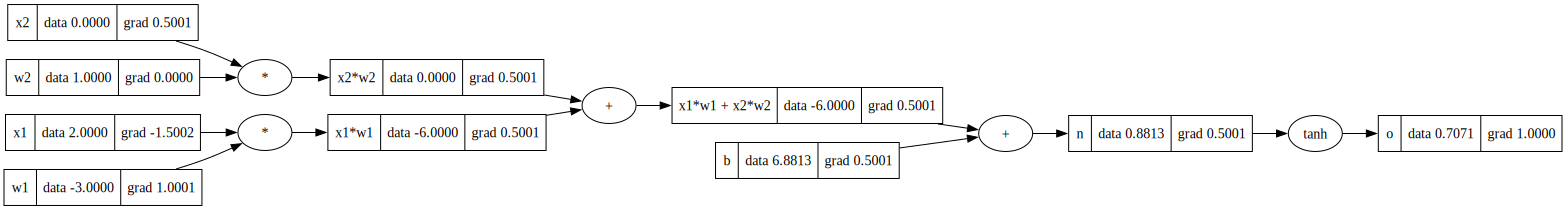

In [158]:
draw_dot(o)

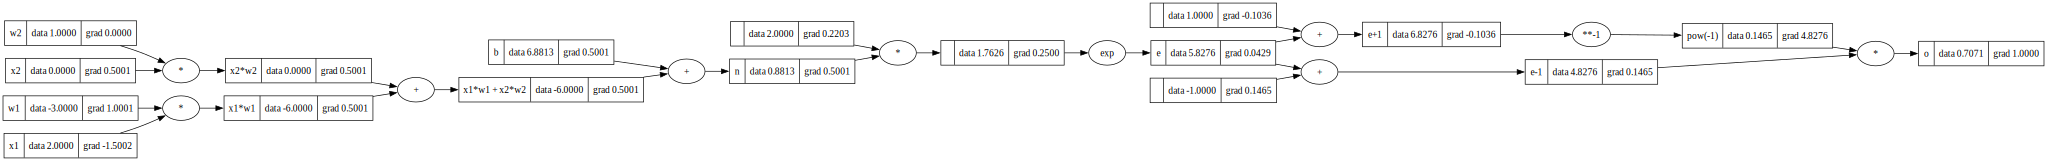

In [171]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813, label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 *n).exp()
e.label = 'e'
eminus1 = (e-1)
eminus1.label = 'e-1'
eplus1 = (e+1)
eplus1.label = 'e+1'
o = eminus1/eplus1
o.label='o'
o.backward()
draw_dot(o)

    # PyTorch implementation

In [107]:
import torch
import random

In [108]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813]).double(); b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print ('-------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7070699720278941
-------
x2 0.5000520546564731
w2 0.0
x1 -1.5001561639694192
w1 1.0001041093129461


In [580]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w = x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

In [587]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=0.7553269704365645)

In [588]:
n.parameters()

[Value(data=-0.7601431935961931),
 Value(data=-0.7807261666883074),
 Value(data=0.44107591681600655),
 Value(data=0.7157110614167097),
 Value(data=-0.8738535940527108),
 Value(data=-0.030105030192558724),
 Value(data=-0.5592602878877555),
 Value(data=-0.6197096465908905),
 Value(data=0.553220499023539),
 Value(data=0.1195099937284092),
 Value(data=-0.49304867252621043),
 Value(data=0.7715137355030199),
 Value(data=-0.1466125073522937),
 Value(data=-0.9977664671231528),
 Value(data=-0.16133897175832024),
 Value(data=0.9179592051654832),
 Value(data=0.14478174440891478),
 Value(data=-0.020522802959681563),
 Value(data=0.9008452969318501),
 Value(data=0.5837236216405299),
 Value(data=-0.20549464333069034),
 Value(data=-0.354051768426495),
 Value(data=-0.3628457242718508),
 Value(data=-0.298483203760195),
 Value(data=0.14747733924977013),
 Value(data=-0.49068430485409786),
 Value(data=0.13463725435875507),
 Value(data=0.9958315717086326),
 Value(data=0.9233334855243589),
 Value(data=0.3592

In [589]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # target

In [592]:
for k in range(50):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # MSE
    
    # backward pass
    # zero grad set gradients to zero
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    loss_val = loss.data
    
    print(f"iteration: {k}, loss: {loss.data}")
    
    

    

iteration: 0, loss: 0.0009982796654968082
iteration: 1, loss: 0.0009965970961295888
iteration: 2, loss: 0.0009949200756906524
iteration: 3, loss: 0.0009932485769060004
iteration: 4, loss: 0.0009915825726796723
iteration: 5, loss: 0.0009899220360923206
iteration: 6, loss: 0.0009882669403997028
iteration: 7, loss: 0.0009866172590313482
iteration: 8, loss: 0.0009849729655890852
iteration: 9, loss: 0.0009833340338456743
iteration: 10, loss: 0.0009817004377434297
iteration: 11, loss: 0.0009800721513928332
iteration: 12, loss: 0.0009784491490712392
iteration: 13, loss: 0.000976831405221466
iteration: 14, loss: 0.0009752188944504778
iteration: 15, loss: 0.0009736115915281518
iteration: 16, loss: 0.000972009471385855
iteration: 17, loss: 0.0009704125091152324
iteration: 18, loss: 0.000968820679966943
iteration: 19, loss: 0.0009672339593493294
iteration: 20, loss: 0.000965652322827221
iteration: 21, loss: 0.0009640757461206553
iteration: 22, loss: 0.0009625042051036932
iteration: 23, loss: 0.00

In [591]:
ypred

[Value(data=0.9877208292475319),
 Value(data=-0.9850793896290271),
 Value(data=-0.980765474130468),
 Value(data=0.9839813178566584)]

In [562]:
n.layers[0].neurons[0].w[0].grad

-0.00017644818758616167

In [500]:
n.layers[0].neurons[0].w[0].data

0.7950436783979261

In [501]:
for p in n.pramaters():
    p.data += -0.001 * p.grad

In [514]:
ypred

[Value(data=0.9962817571456486),
 Value(data=-0.9995747327896958),
 Value(data=-0.9999133520287844),
 Value(data=0.9957861172209369)]

In [504]:
n.pramaters()

[Value(data=0.7933063712623097),
 Value(data=0.3027007775435378),
 Value(data=0.9588123527258533),
 Value(data=0.5842954930314332),
 Value(data=-0.12084167016581708),
 Value(data=2.9609867000391143),
 Value(data=-2.671405654230254),
 Value(data=1.1473302637015594),
 Value(data=0.9016258439824228),
 Value(data=-1.686390329129505),
 Value(data=3.346298940244622),
 Value(data=0.400728813984469),
 Value(data=-0.750786913201001),
 Value(data=-0.6667282040998561),
 Value(data=0.2889026842831683),
 Value(data=-0.5797830742310681),
 Value(data=0.8157357038426853),
 Value(data=-0.6966892466093696),
 Value(data=0.3917770310548296),
 Value(data=-0.029613798825150223),
 Value(data=-0.6564674367700258),
 Value(data=0.35455611968619505),
 Value(data=1.1542129760325424),
 Value(data=0.8392541741990089),
 Value(data=-0.4698010073329497),
 Value(data=-0.507314314641158),
 Value(data=0.4248987204451283),
 Value(data=-0.5820577187415631),
 Value(data=1.1642515180311668),
 Value(data=0.07923053434045706),